In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [2]:
train_dir = 'C:/Users/fdoktorm/OneDrive - Intel Corporation/Documents/Private/Data Science/Naya College/Final Project Brain Tumor Classification/Brain-Tumor-Classification-DataSet-master/Training/'
test_dir = 'C:/Users/fdoktorm/OneDrive - Intel Corporation/Documents/Private/Data Science/Naya College/Final Project Brain Tumor Classification/Brain-Tumor-Classification-DataSet-master/Testing/'

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split

In [4]:
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']

In [5]:
for i in categories:
    path = os.path.join(train_dir, i)    
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))       

In [6]:
#This is size of each image - 512x512 with 3 channels (RGB)
img_array.shape

(512, 512, 3)

In [7]:
#Representative example - dark color
img_array[150][150]

array([64, 64, 64], dtype=uint8)

In [8]:
#Image resize to 128 to 128
img_size = 128
image_array = cv2.resize(img_array, (img_size,img_size))

In [9]:
gt1 = cv2.imread(train_dir+'glioma/Tr-gl_0028.jpg')
mt1 = cv2.imread(train_dir+'meningioma/Tr-me_0030.jpg')
nt1 = cv2.imread(train_dir+'notumor/Tr-no_0035.jpg')
pt1 = cv2.imread(train_dir+'pituitary/Tr-pi_0038.jpg')

## Example of Glioma Tumor

(-0.5, 511.5, 511.5, -0.5)

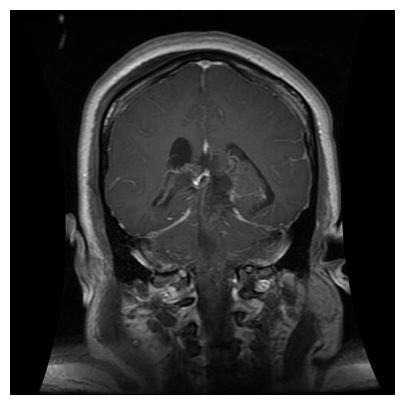

In [10]:
plt.rcParams["figure.figsize"] = (5,5)
plt.imshow(gt1)
plt.axis('off')

## Example of Meningioma Tumor

(-0.5, 511.5, 511.5, -0.5)

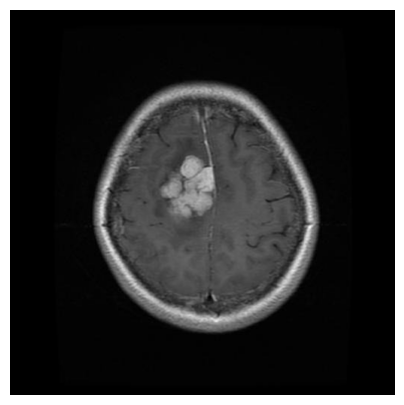

In [11]:
plt.rcParams["figure.figsize"] = (5,5)
plt.imshow(mt1)
plt.axis('off')

## Example of No Tumor

(-0.5, 679.5, 679.5, -0.5)

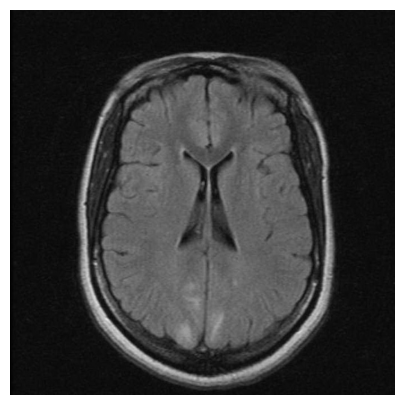

In [12]:
plt.rcParams["figure.figsize"] = (5,5)
plt.imshow(nt1)
plt.axis('off')

## Example of Pituitary Tumor

(-0.5, 1364.5, 1364.5, -0.5)

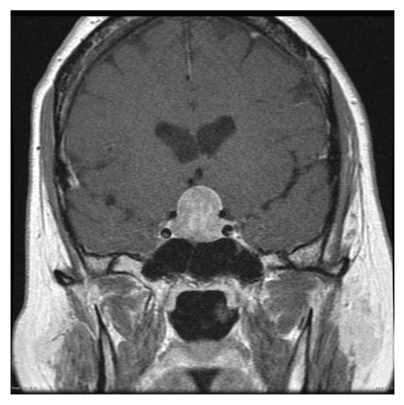

In [13]:
plt.rcParams["figure.figsize"] = (5,5)
plt.imshow(pt1)
plt.axis('off')

## Convert each image to grayscale and append into an array

In [14]:
#Conversion to gray scale image using cv2.IMREAD_GRAYSCALE argument and creation of train data
#Each element of list contains image vector representation in place 0 and classification label in place 1
train_data = []

for i in categories:
    train_path = os.path.join(train_dir,i)
    tag = categories.index(i)
    for img in os.listdir(train_path):
        try:
            image_arr = cv2.imread(os.path.join(train_path , img), cv2.IMREAD_GRAYSCALE)
            new_image_array = cv2.resize(image_arr, (img_size,img_size))
            train_data.append([new_image_array , tag])
        except Exception as e:
            pass

## Split the features and target in to X and y

In [15]:
X = []
y = []
for i,j in train_data:
    X.append(i)
    y.append(j)
X = np.array(X).reshape(-1,img_size,img_size)
print(X.shape)
#print(X[0])
X = X/255.0
#print(X[0])
X = X.reshape(-1,128,128,1)
#print(X.shape)
#print(X)

(5712, 128, 128)


In [16]:
from keras.utils.np_utils import to_categorical   

y_enc = to_categorical(y, num_classes = 4)

### Split the data into Train, Validation and Test dataset (80%-10%-10%)

In [17]:
X_train , X_test, y_train, y_test = train_test_split(X , y_enc , test_size = 0.2, random_state = 42)
X_train , X_val, y_train, y_val = train_test_split(X_train , y_train , test_size = 0.2, random_state = 42)

## Import keras' functions to create CNN model

In [18]:
from sklearn.metrics import confusion_matrix
import itertools
from keras.utils.vis_utils import plot_model
from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

model = Sequential()


model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (128,128,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))


model.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(1024, activation = "relu"))
model.add(Dropout(0.5))

model.add(Dense(4, activation = "softmax"))

optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

epochs = 15

es = EarlyStopping(
    monitor='loss', 
    mode='max',
    patience = 20
)

batch_size = 16
imggen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=0,
        zoom_range = 0,
        width_shift_range=0,  
        height_shift_range=0,  
        horizontal_flip=True,  
        vertical_flip=False)

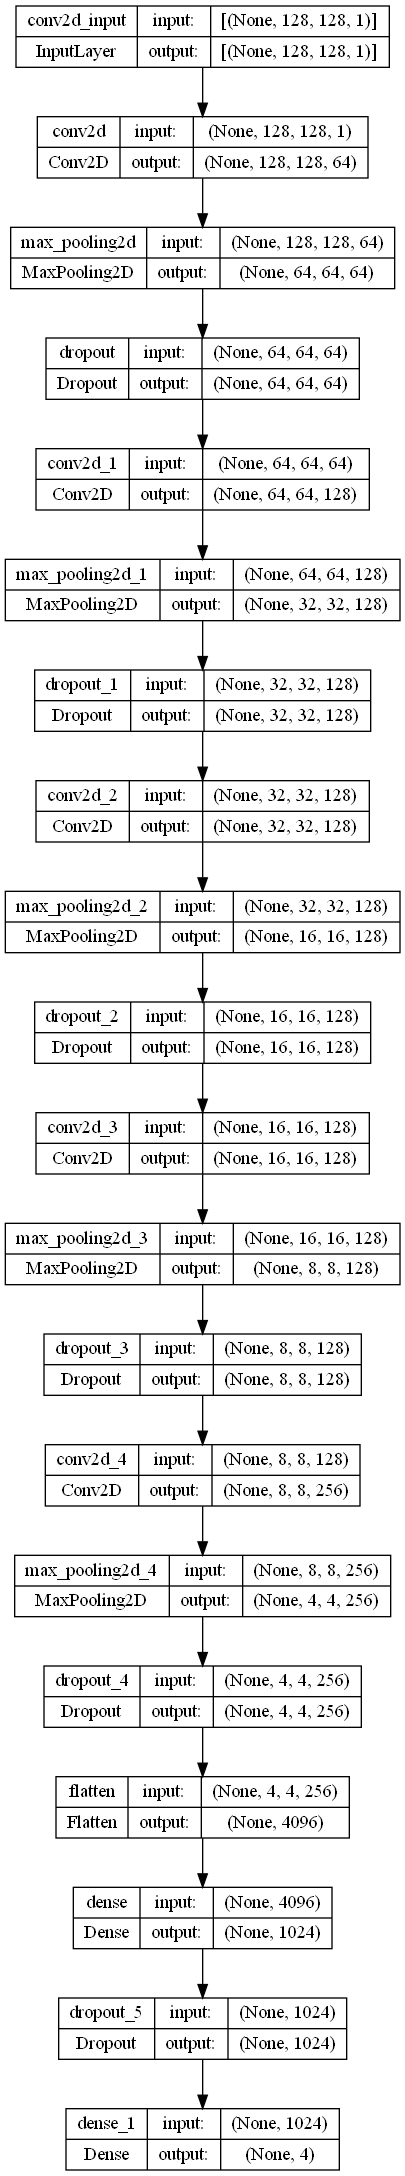

In [19]:
plot_model(model, show_shapes=True, show_layer_names=True)

## Fit the model with Train and Validation datatsets

In [20]:
imggen.fit(X_train)
history = model.fit(imggen.flow(X_train,y_train,batch_size = batch_size),
                              epochs = epochs, validation_data = (X_val,y_val),
                              steps_per_epoch = X_train.shape[0] // batch_size,
                              callbacks = [es])    

Epoch 1/15
228/228 [==============================] - 70s 302ms/step - loss: 0.9359 - accuracy: 0.5919 - val_loss: 0.7437 - val_accuracy: 0.7265
Epoch 2/15
228/228 [==============================] - 72s 314ms/step - loss: 0.6125 - accuracy: 0.7639 - val_loss: 0.6931 - val_accuracy: 0.7123
Epoch 3/15
228/228 [==============================] - 70s 308ms/step - loss: 0.5110 - accuracy: 0.7953 - val_loss: 0.4670 - val_accuracy: 0.8085
Epoch 4/15
228/228 [==============================] - 66s 290ms/step - loss: 0.4319 - accuracy: 0.8282 - val_loss: 0.4821 - val_accuracy: 0.8053
Epoch 5/15
228/228 [==============================] - 67s 294ms/step - loss: 0.3921 - accuracy: 0.8439 - val_loss: 0.3421 - val_accuracy: 0.8654
Epoch 6/15
228/228 [==============================] - 71s 312ms/step - loss: 0.3680 - accuracy: 0.8593 - val_loss: 0.3207 - val_accuracy: 0.8742
Epoch 7/15
228/228 [==============================] - 66s 290ms/step - loss: 0.3145 - accuracy: 0.8805 - val_loss: 0.2346 - val_ac

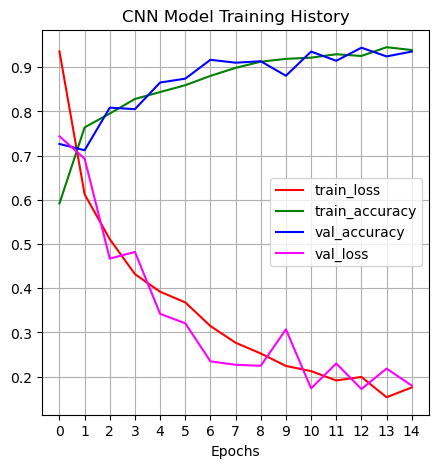

In [21]:
plt.plot(history.history["loss"],c = "red")
plt.plot(history.history["accuracy"],c = "green")
plt.plot(history.history['val_accuracy'], c = "blue")
plt.plot(history.history['val_loss'], c = "magenta")
plt.grid(True)
plt.title("CNN Model Training History")
plt.xlabel("Epochs")
plt.xticks([x for x in range(epochs)])
plt.legend(["train_loss", "train_accuracy",'val_accuracy','val_loss'])
plt.rcParams["figure.figsize"] = (7,8)
plt.show()

In [22]:
score = model.evaluate(X_test, y_test, verbose = 3)
score[1]

0.9335083365440369